In [1]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from urllib.request import urlopen

2024-07-23 04:08:32.974763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 04:08:32.974917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 04:08:33.149649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    epochs = 20
    batch_size = 32
    classes = [
        "ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam",
        "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress",
        "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats",
        "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",
        "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen",
        "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics",
        "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow",
        "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump",
        "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow",
        "JugglingBalls", "JumpingJack", "JumpRope", "Kayaking", "Knitting",
        "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor",
        "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf",
        "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar",
        "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
        "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing",
        "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding",
        "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty",
        "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot",
        "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing",
        "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard",
        "YoYo"
    ]
    videos_per_class = 5

In [3]:
def format_frames(frame, output_size):
  
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
 
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=0.1)

In [4]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [5]:
def save_model(model, filepath):
    model.save(filepath)

In [6]:
def classify_video_url(model, video_url, n_frames=10):
  
    video = urlopen(video_url)
    with open('temp_video.avi', 'wb') as f:
        f.write(video.read())

    video_frames = frames_from_video_file('temp_video.avi', n_frames=n_frames)

    predictions = model.predict(np.expand_dims(video_frames, axis=0))

    predicted_class = np.argmax(predictions)
    predicted_class_name = CFG.classes[predicted_class]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

In [7]:
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF-101/{cls}/**.avi")[:CFG.videos_per_class]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [8]:
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
print(sample_video.shape)
to_gif(sample_video)

(10, 224, 224, 3)


In [9]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))
features = np.array(features)

  0%|          | 0/505 [00:00<?, ?it/s]

In [10]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [12]:
del train_features
del val_features
gc.collect()

18

In [13]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [14]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(CFG.classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
history = efficient_net_model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.weights.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/20


I0000 00:00:1721708109.107832     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 620s 25s/step - accuracy: 0.0205 - loss: 4.6385 - val_accuracy: 0.1089 - val_loss: 4.3395
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - accuracy: 0.4323 - loss: 3.5871 - val_accuracy: 0.1881 - val_loss: 3.9420
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step - accuracy: 0.6988 - loss: 2.9262 - val_accuracy: 0.3267 - val_loss: 3.5636
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 601ms/step - accuracy: 0.8285 - loss: 2.3721 - val_accuracy: 0.4158 - val_loss: 3.2181
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step - accuracy: 0.8900 - loss: 1.9066 - val_accuracy: 0.4554 - val_loss: 2.9313
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 604ms/step - accuracy: 0.9292 - loss: 1.5528 - val_accuracy: 0.4950 - val_loss: 2.7059
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step - accuracy: 0.9671 - loss: 1.2759 - val_accuracy: 0.5347 - val_loss: 2.5355
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step - accuracy: 0.9758 - loss: 1.0669 - val_accuracy: 0.5644 - val_

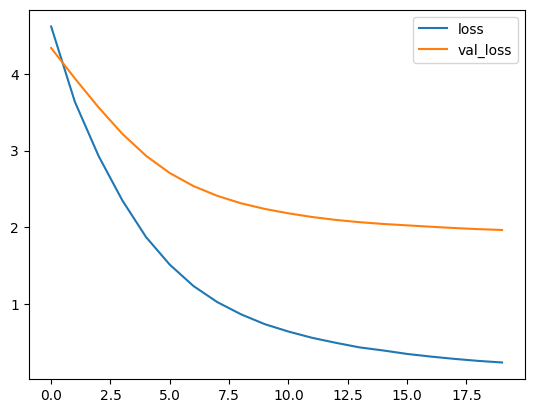

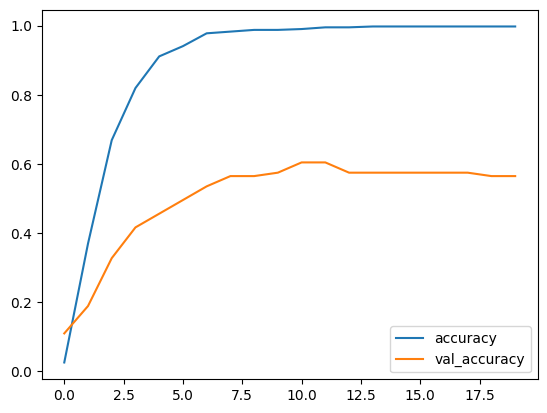

In [16]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [17]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.5507 - loss: 2.0068
Validation Loss: 1.962780237197876 Validation Accuracy: 0.5643564462661743


In [18]:
val_predictions = np.argmax(efficient_net_model.predict(valid_ds), axis=1)
plot_confusion_matrix(val_targets, val_predictions, CFG.classes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 92s 16s/step


In [19]:
save_model(efficient_net_model, "Video_Classification_Model.h5")